In [1]:
from __future__ import print_function
from __future__ import division
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
sns.set_context(rc={'figure.figsize': (14, 7) } )
figzize_me = figsize =(14, 7)
# import warnings; 
# warnings.filterwarnings('ignore')

import os
import sys
# 使用insert 0即只使用github，避免交叉使用了pip安装的abupy，导致的版本不一致问题
sys.path.insert(0, os.path.abspath('../'))

import abupy as abu
print(sys.version)

3.7.1 (default, Dec 10 2018, 22:54:23) [MSC v.1915 64 bit (AMD64)]


In [2]:
# get Micron data 
df = abu.ABuSymbolPd.make_kl_df('usMU')
# show top 5 rows of data fetched 
print(df.iloc[0:5])


             atr14   atr21  close      date  date_week   high  key    low  \
2017-03-17  0.6400  0.6400  25.80  20170317          4  25.91    0  25.40   
2017-03-20  0.7257  0.7238  26.21  20170320          0  26.61    1  25.81   
2017-03-21  0.8343  0.8284  25.52  20170321          1  26.44    2  25.43   
2017-03-22  0.7565  0.7572  26.06  20170322          2  26.15    3  25.63   
2017-03-23  0.8122  0.8082  26.47  20170323          3  26.49    4  26.04   

             open  p_change  pre_close    volume  
2017-03-17  25.86    -0.922      26.04  19126498  
2017-03-20  25.99     1.589      25.80  26918811  
2017-03-21  26.30    -2.633      26.21  28397518  
2017-03-22  25.73     2.116      25.52  25092530  
2017-03-23  26.36     1.573      26.06  47118274  


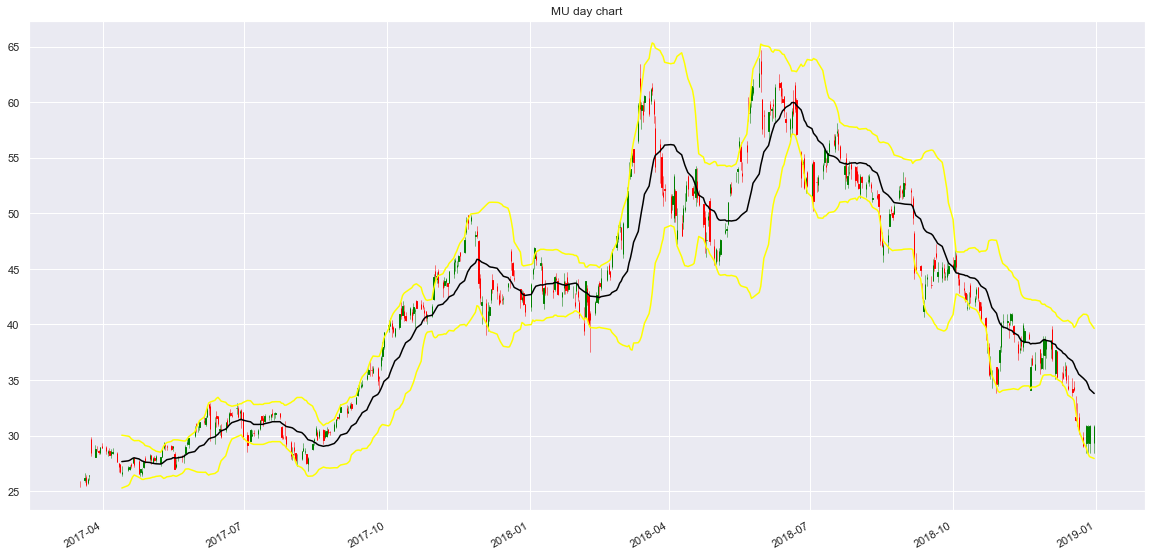

In [3]:
# plot candlestick chart 
import mpl_finance as mpf
import matplotlib.dates as dates

__colorUp__ = 'green'
__colorDown__ = 'red'
fig, ax = plt.subplots(figsize = (20,10))
qutotes = []
for index, (d,o,c,h,l,v) in enumerate(zip(df.index,df.open,df.close, df.high,df.low,df.volume)):
    d = dates.date2num(d)
    val = (d,o,c,h,l,v)
    qutotes.append(val)
mpf.candlestick_ochl(ax, qutotes,colorup = __colorUp__ ,colordown = __colorDown__)

plt.title('{} day chart'.format(str('MU')))

# add bolligerbands
sma20 = df.close.rolling(20).mean()
upBband = sma20 + 2*df.close.rolling(20).std()
downBband = sma20 - 2*df.close.rolling(20).std()
sma20.plot(color = 'black')
upBband.plot(color = 'yellow')
downBband.plot(color = 'yellow')
ax.autoscale_view()
ax.xaxis_date()



In [4]:
from abupy import AbuFactorBuyBase
from abupy import AbuBenchmark
from abupy import AbuFactorBuyBreak
from abupy import BuyCallMixin
#define Buy long factor

class customBuyBreak(AbuFactorBuyBase,BuyCallMixin):
    def _init_self(self, **kwargs):
        """kwargs中必须包含: 突破参数xd 比如20，30，40天...突破"""
        # 突破参数 xd， 比如20，30，40天...突破, 不要使用kwargs.pop('xd', 20), 明确需要参数xq
        self.xd = kwargs['xd']
        # 在输出生成的orders_pd中显示的名字
        self.factor_name = '{}:{}'.format(self.__class__.__name__, self.xd)

    def fit_day(self, today):
        """
        针对每一个交易日拟合买入交易策略，寻找向上突破买入机会
        :param today: 当前驱动的交易日金融时间序列数据
        :return:
        """
       
        
        # 忽略不符合买入的天（统计周期内前xd天）
        if self.today_ind < self.xd - 1:
            return None

        # 今天的收盘价格达到xd天内最高价格则符合买入条件
        #SMA(50) > SMA(100) confirm solid uptrend
        sma50 = self.kl_pd.close[self.today_ind - 50 + 1:self.today_ind + 1].mean()
        sma100 = self.kl_pd.close[self.today_ind - 100 + 1:self.today_ind + 1].mean()
        upTrend = True if sma50 > sma100 else False
        
        if today.close == self.kl_pd.close[self.today_ind - self.xd + 1:self.today_ind + 1].max() and upTrend:
            # 把突破新高参数赋值skip_days，这里也可以考虑make_buy_order确定是否买单成立，但是如果停盘太长时间等也不好       
                self.skip_days = self.xd
            # 生成买入订单, 由于使用了今天的收盘价格做为策略信号判断，所以信号发出后，只能明天买
                return self.buy_tomorrow()
            
        return None
        """示例正向突破买入择时类，混入BuyCallMixin，即向上突破触发买入event"""
    
    
buy_factors = [{'xd': 50, 'class': customBuyBreak}]
benchmark = AbuBenchmark()

from abupy import AbuPickTimeWorker 
from abupy import AbuCapital
from abupy import AbuKLManager

capital = AbuCapital(1000000, benchmark)
kl_pd_manager = AbuKLManager(benchmark, capital)

kl_pd = kl_pd_manager.get_pick_time_kl_pd('usMU')
abu_worker = AbuPickTimeWorker(capital, kl_pd, benchmark, buy_factors, None)
%time abu_worker.fit()

Wall time: 191 ms


FloatProgress(value=0.0)

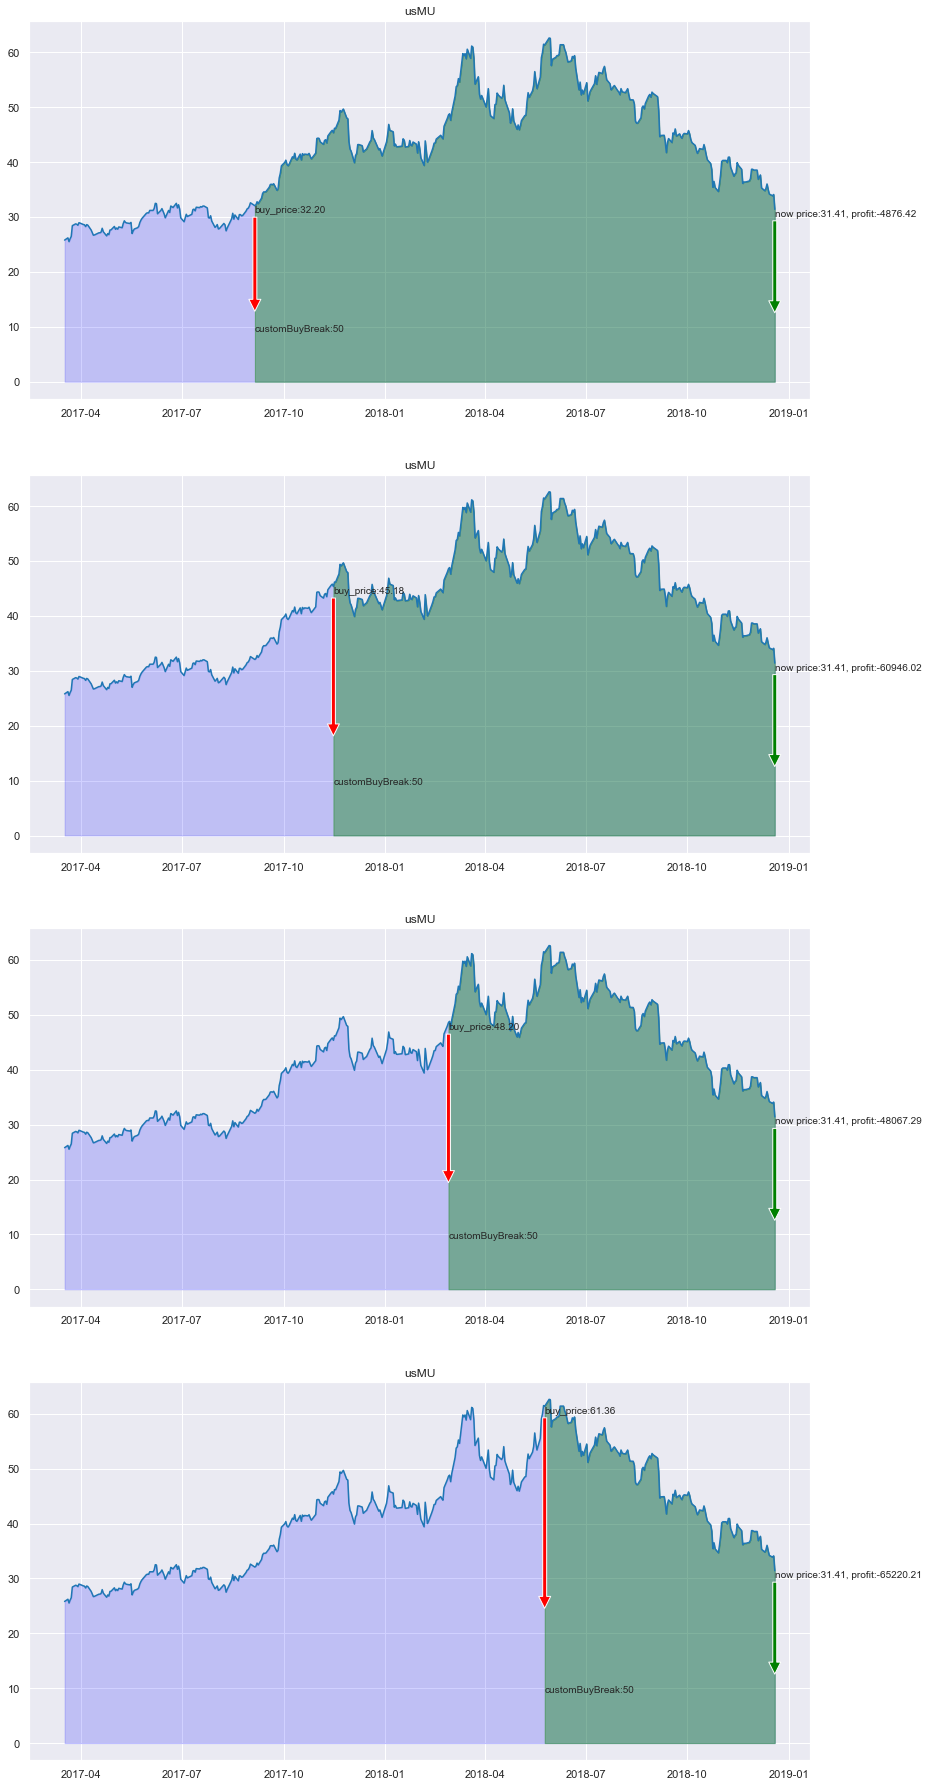

In [5]:
from abupy import ABuTradeProxy
orders_pd, action_pd, _ = ABuTradeProxy.trade_summary(abu_worker.orders, kl_pd, draw=True)

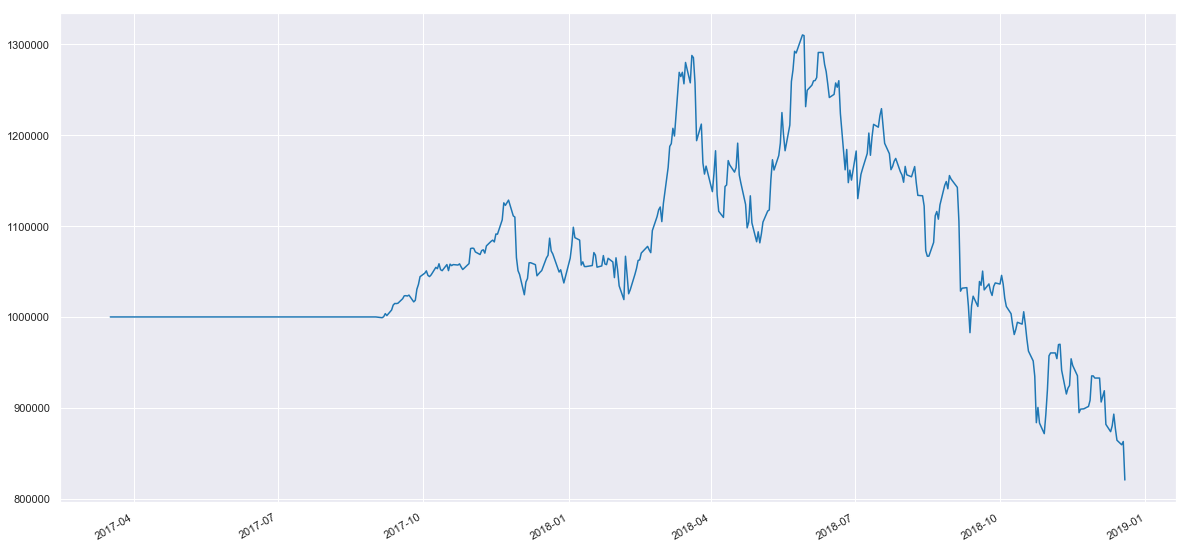

In [6]:
from abupy import ABuTradeExecute
ABuTradeExecute.apply_action_to_capital(capital, action_pd, kl_pd_manager)
capital.capital_pd.capital_blance.plot(figsize = (20,10))

Box(children=(Text(value='pid=9848 begin work'), FloatProgress(value=0.0)))

FloatProgress(value=0.0)

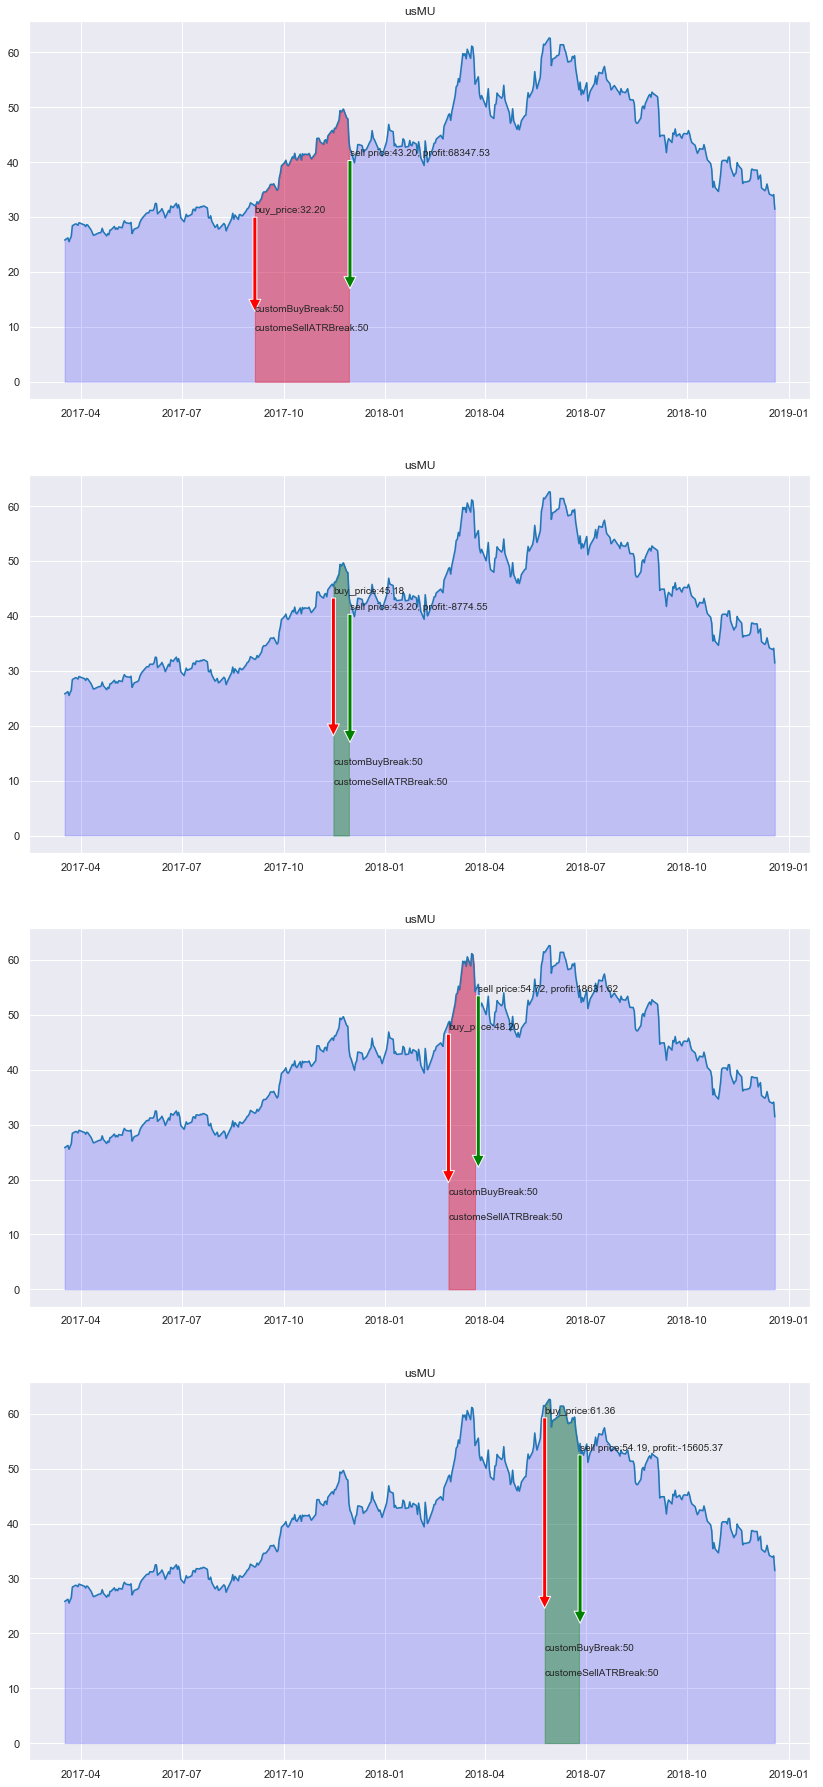

In [22]:
# construct Sell factor
from abupy import ABuPickTimeExecute
from abupy import AbuFactorAtrNStop
from abupy import AbuFactorSellBase
from abupy.IndicatorBu.ABuNDAtr import _calc_atr_from_pd as atr
from abupy import AbuFactorSellBreak
from abupy import ESupportDirection
import datetime

# define CustomSellFactor Class 

class customeSellATRBreak(AbuFactorSellBase):
    """示例向下突破卖出择时因子"""

    def _init_self(self, **kwargs):
        """kwargs中必须包含: 突破参数xd 比如20，30，40天...突破"""

        # 向下突破参数 xd， 比如20，30，40天...突破
        self.xd = kwargs['xd']
        # 在输出生成的orders_pd中显示的名字
        self.sell_type_extra = '{}:{}'.format(self.__class__.__name__, self.xd)

    def support_direction(self):
        """支持的方向，只支持正向"""
        return [ESupportDirection.DIRECTION_CAll.value]
    
    def fit_day(self, today, orders):
        """
        寻找向下突破作为策略卖出驱动event
        :param today: 当前驱动的交易日金融时间序列数据
        :param orders: 买入择时策略中生成的订单序列
        
        """
        # 今天的收盘价格达到xd天内最低价格则符合条件
        if self.kl_pd.close[0:self.today_ind + 1].shape[0] > 100 and len(orders) != 0:
            atr100 = atr(self.kl_pd.high[:self.today_ind],self.kl_pd.low[:self.today_ind],self.kl_pd.close[:self.today_ind],time_period = 100)[-1]
            # this needed to be modify, now this is using the highest of the last 50 days, but instead we need to find the highest after we open our long position
          
            today_date = datetime.datetime.strptime(str(int(today.date)), '%Y%m%d')
            open_date =  datetime.datetime.strptime(str(int(orders[-1].buy_date)), '%Y%m%d')  
            highestValue = max(self.kl_pd.loc[open_date:today_date,'close'].max(),orders[-1].buy_price)
   
    
            #highestValue = self.kl_pd.close[self.today_ind - self.xd + 1:self.today_ind + 1].max()
            
            stopExit = True if today.close <=  highestValue - 3*atr100 else False
            if stopExit:
                for order in orders:
                    self.sell_tomorrow(order)   

       


 
        

sell_factor = {'xd': 50, 'class': customeSellATRBreak}
sell_factors = [sell_factor]
capital = AbuCapital(1000000, benchmark)
orders_pd, action_pd, _ = ABuPickTimeExecute.do_symbols_with_same_factors(
                          ['usMU'], benchmark, buy_factors, sell_factors, capital, show=True)

            buy_date  buy_price  buy_cnt         buy_factor symbol  \
2017-09-05  20170905     32.195   6212.0  customBuyBreak:50   usMU   
2017-11-15  20171115     45.180   4426.0  customBuyBreak:50   usMU   
2018-02-27  20180227     48.205   2862.0  customBuyBreak:50   usMU   
2018-05-25  20180525     61.355   2178.0  customBuyBreak:50   usMU   

                   buy_pos buy_type_str  expect_direction  \
2017-09-05  AbuAtrPosition         call               1.0   
2017-11-15  AbuAtrPosition         call               1.0   
2018-02-27  AbuAtrPosition         call               1.0   
2018-05-25  AbuAtrPosition         call               1.0   

                   sell_type_extra  sell_date  sell_price sell_type  \
2017-09-05  customeSellATRBreak:50   20171130     43.1975       win   
2017-11-15  customeSellATRBreak:50   20171130     43.1975      loss   
2018-02-27  customeSellATRBreak:50   20180326     54.7150       win   
2018-05-25  customeSellATRBreak:50   20180626     54.1900  

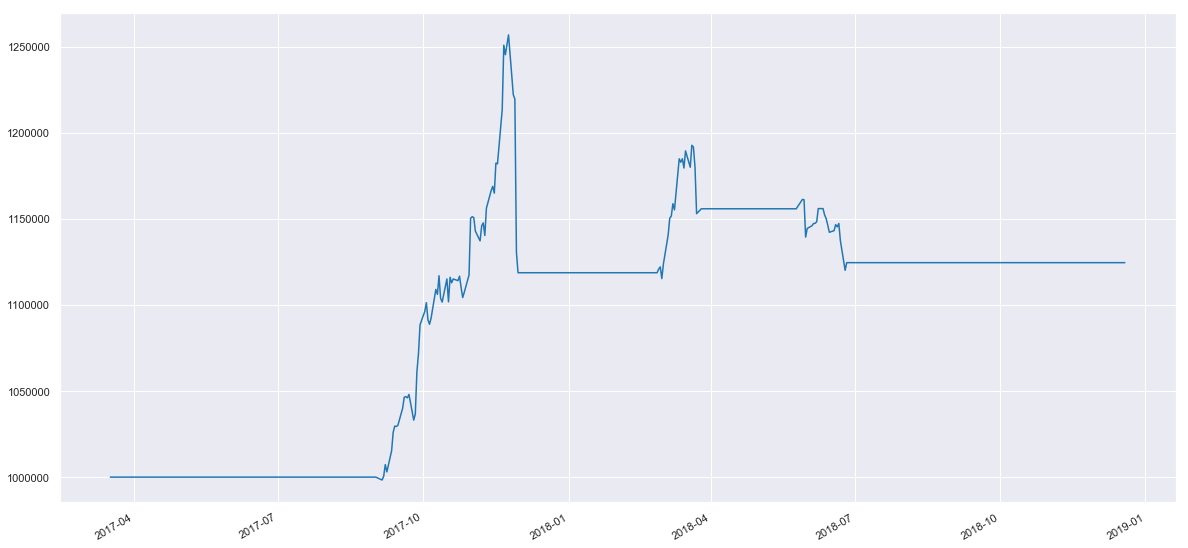

In [23]:
ABuTradeExecute.apply_action_to_capital(capital, action_pd, kl_pd_manager)
capital.capital_pd.capital_blance.plot(figsize = (20,10))
print(orders_pd)